Natural Language Processing (NLP) is a unique subset of Machine Learning which cares about the real life unstructured data. Although computers cannot identify and process the string inputs, the libraries like NLTK, TextBlob and many others found a way to process string mathematically. Twitter is a platform where most of the people express their feelings towards the current context. In this Notebook i will search data; Covid-19 data mostly and then stream from twitter. Then i will filter the data and do some analysis on the data. I will use Twitter API get the data from twitter.

First we will import the libraries that we will be using in this project.

In [1]:
import sys
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import re
import string

# to view all columns
pd.set_option("display.max.columns", None)

In [ ]:
#Import the necessary methods from tweepy library  

#install tweepy if you don't have it
!pip install tweepy
import tweepy
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream

#sentiment analysis package
#!pip install textblob
from textblob import TextBlob

#general text pre-processor
!pip install nltk
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

#tweet pre-processor 
!pip install tweet-preprocessor
import preprocessor as p

This is a python code(python classes and functions) that will illustrate and assist in searching and fetching data from twitter.

In [15]:
class tweetsearch():
    '''
    This is a basic class to search and download twitter data.
    You can build up on it to extend the functionalities for more 
    sophisticated analysis
    '''
    def __init__(self, cols=None,auth=None):
        #
        if not cols is None:
            self.cols = cols
        else:
            self.cols = ['id', 'created_at', 'source', 'original_text','clean_text', 
                    'sentiment','polarity','subjectivity', 'lang',
                    'favorite_count', 'retweet_count', 'original_author',   
                    'possibly_sensitive', 'hashtags',
                    'user_mentions', 'place', 'place_coord_boundaries']
            
        if auth is None:
            '''
            #Variables that contains the user credentials to access Twitter API 
            consumer_key = os.environ.get('2fGZDlTA6gcS0aqc3Vs9RkUsx')
            consumer_secret = os.environ.get('KFFI3FcgY90NKtG1IReTWj4sQ77Y9osnFK0OoX9fUVuz44iEry')
            access_token = os.environ.get('990262908696387584-HTgPRm2tySXaq7nBHeY1rhhKdV6umNe')
            access_token_secret = os.environ.get('5BTPHpjJl7JewU2mwd3qCek716Fyz8Q3AgDhgJIYxQ2hO')
            '''


            #This handles Twitter authetification and the connection to Twitter Streaming API
            auth = OAuthHandler('2fGZDlTA6gcS0aqc3Vs9RkUsx', 'KFFI3FcgY90NKtG1IReTWj4sQ77Y9osnFK0OoX9fUVuz44iEry')
            auth.set_access_token('990262908696387584-HTgPRm2tySXaq7nBHeY1rhhKdV6umNe', '5BTPHpjJl7JewU2mwd3qCek716Fyz8Q3AgDhgJIYxQ2hO')
            

        #            
        self.auth = auth
        self.api = tweepy.API(auth) 
        self.filtered_tweet = ''
            

    def clean_tweets(self, twitter_text):

        #use pre processor
        tweet = p.clean(twitter_text)

         #HappyEmoticons
        emoticons_happy = set([
            ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
            ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
            '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
            'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
            '<3'
            ])

        # Sad Emoticons
        emoticons_sad = set([
            ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
            ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
            ':c', ':{', '>:\\', ';('
            ])

        #Emoji patterns
        emoji_pattern = re.compile("["
                 u"\U0001F600-\U0001F64F"  # emoticons
                 u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                 u"\U0001F680-\U0001F6FF"  # transport & map symbols
                 u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                 u"\U00002702-\U000027B0"
                 u"\U000024C2-\U0001F251"
                 "]+", flags=re.UNICODE)

        #combine sad and happy emoticons
        emoticons = emoticons_happy.union(emoticons_sad)

        stop_words = set(stopwords.words('english'))
        word_tokens = nltk.word_tokenize(tweet)
        #after tweepy preprocessing the colon symbol left remain after      
        #removing mentions
        tweet = re.sub(r':', '', tweet)
        tweet = re.sub(r'‚Ä¶', '', tweet)

        #replace consecutive non-ASCII characters with a space
        tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)

        #remove emojis from tweet
        tweet = emoji_pattern.sub(r'', tweet)

        #filter using NLTK library append it to a string
        filtered_tweet = [w for w in word_tokens if not w in stop_words]

        #looping through conditions
        filtered_tweet = []    
        for w in word_tokens:
        #check tokens against stop words , emoticons and punctuations
            if w not in stop_words and w not in emoticons and w not in string.punctuation:
                filtered_tweet.append(w)

        return ' '.join(filtered_tweet)            

    def get_tweets(self, keyword, csvfile=None):
        
        
        df = pd.DataFrame(columns=self.cols)
        
        if not csvfile is None:
            #If the file exists, then read the existing data from the CSV file.
            if os.path.exists(csvfile):
                df = pd.read_csv(csvfile, header=0)
            

        #page attribute in tweepy.cursor and iteration
        for page in tweepy.Cursor(self.api.search, q=keyword,count=200, include_rts=False).pages():

            # the you receive from the Twitter API is in a JSON format and has quite an amount of information attached
            for status in page:
                
                new_entry = []
                status = status._json
                
                #filter by language
                if status['lang'] != 'en':
                    continue

                
                #if this tweet is a retweet update retweet count
                if status['created_at'] in df['created_at'].values:
                    i = df.loc[df['created_at'] == status['created_at']].index[0]
                    #
                    cond1 = status['favorite_count'] != df.at[i, 'favorite_count']
                    cond2 = status['retweet_count'] != df.at[i, 'retweet_count']
                    if cond1 or cond2:
                        df.at[i, 'favorite_count'] = status['favorite_count']
                        df.at[i, 'retweet_count'] = status['retweet_count']
                    continue

                #calculate sentiment
                filtered_tweet = self.clean_tweets(status['text'])
                blob = TextBlob(filtered_tweet)
                Sentiment = blob.sentiment     
                polarity = Sentiment.polarity
                subjectivity = Sentiment.subjectivity

                new_entry += [status['id'], status['created_at'],
                              status['source'], status['text'], filtered_tweet, 
                              Sentiment,polarity,subjectivity, status['lang'],
                              status['favorite_count'], status['retweet_count']]

                new_entry.append(status['user']['screen_name'])

                try:
                    is_sensitive = status['possibly_sensitive']
                except KeyError:
                    is_sensitive = None

                new_entry.append(is_sensitive)

                hashtags = ", ".join([hashtag_item['text'] for hashtag_item in status['entities']['hashtags']])
                new_entry.append(hashtags) #append the hashtags

                #
                mentions = ", ".join([mention['screen_name'] for mention in status['entities']['user_mentions']])
                new_entry.append(mentions) #append the user mentions

                try:
                    xyz = status['place']['bounding_box']['coordinates']
                    coordinates = [coord for loc in xyz for coord in loc]
                except TypeError:
                    coordinates = None
                #
                new_entry.append(coordinates)

                try:
                    location = status['user']['location']
                except TypeError:
                    location = ''
                #
                new_entry.append(location)

                #now append a row to the dataframe
                single_tweet_df = pd.DataFrame([new_entry], columns=self.cols)
                df = df.append(single_tweet_df, ignore_index=True)

        if not csvfile is None:
            #save it to file
            df.to_csv(csvfile, columns=self.cols, index=False, encoding="utf-8")
            
        return df

Now we search twitter and fetch data

In [30]:
covid_keywords = '#COVID19Kenya'  #hashtag based search
#tweets_file = 'data/kenya_covid19_12july2020.json'

#get file if you have already downloaded what you wanted
#df = pd.read_csv(tweets_file, header=0)

##get data on keywords
ts = tweetsearch()
df = ts.get_tweets(covid_keywords)    #you saved the 
df

,id,created_at,source,original_text,clean_text,sentiment,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,possibly_sensitive,hashtags,user_mentions,place,place_coord_boundaries
0,1282337054014279682,Sun Jul 12 15:32:33 +0000 2020,"<a href=""http://twitter.com/download/android"" ...",RT @Tembeayouth: Tembea Youth Centre for susta...,Tembea Youth Centre sustainable development re...,"(0.0, 0.0)",0.000000,0.000000,en,0,4,Hillary95029461,None,,Tembeayouth,None,"Siaya, Kenya"
1,1282332536513933312,Sun Jul 12 15:14:35 +0000 2020,"<a href=""http://twitter.com/download/android"" ...",What model of managing Covid-19 did Kenya adop...,What model managing Covid-19 Kenya adopt Tanza...,"(0.0, 0.75)",0.000000,0.750000,en,0,0,MartinS57527599,False,,,None,
2,1282328894385934338,Sun Jul 12 15:00:07 +0000 2020,"<a href=""https://mobile.twitter.com"" rel=""nofo...",Dr. Mercy at @MOH_Kenya was hoping for 10K cas...,Dr. Mercy hoping K cases April I see today fin...,"(0.0, 1.0)",0.000000,1.000000,en,0,0,ellekgwriter,False,,MOH_Kenya,None,"Mombasa County, Kenya"
3,1282325505149153280,Sun Jul 12 14:46:39 +0000 2020,"<a href=""http://twitter.com/download/android"" ...","Where is the testing happening? 7,050! #FAQ\n...",Where testing happening,"(0.0, 0.0)",0.000000,0.000000,en,0,0,RKDAVID1,False,"FAQ, covid19kenya",MOH_Kenya,None,Earth
4,1282322372675153920,Sun Jul 12 14:34:12 +0000 2020,"<a href=""http://twitter.com/download/iphone"" r...",RT @kiddoGAMMZ: #covid19kenya Painful times fo...,Painful times Kenyan media industry ... Cartoon,"(-0.7, 0.9)",-0.700000,0.900000,en,0,8,HabBradley,None,"covid19kenya, COVID19, Media","kiddoGAMMZ, StandardKenya, SDEKenya",None,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1270,1279313086353211392,Sat Jul 04 07:16:22 +0000 2020,"<a href=""http://twitter.com/download/iphone"" r...",RT @LifeinMombasa: Since March 13th when we go...,Since March th got first Covid-19 case things ...,"(0.21666666666666667, 0.31111111111111106)",0.216667,0.311111,en,0,4,Kipkoech_the4th,None,,LifeinMombasa,None,"Eldoret, Kenya"
1271,1279297094793285632,Sat Jul 04 06:12:50 +0000 2020,"<a href=""http://twitter.com/download/android"" ...",RT @Walidbadawi: Covid-19 is challenging Kenya...,Covid-19 challenging Kenya keep development pr...,"(0.5, 1.0)",0.500000,1.000000,en,0,16,realDanielJuma,None,covid19kenya,"Walidbadawi, UNDPKenya",None,Nairobi Kenya
1272,1279269028528340993,Sat Jul 04 04:21:18 +0000 2020,"<a href=""http://twitter.com/download/iphone"" r...",RT @LifeinMombasa: Since March 13th when we go...,Since March th got first Covid-19 case things ...,"(0.21666666666666667, 0.31111111111111106)",0.216667,0.311111,en,0,4,MombasaCountyKe,None,,LifeinMombasa,None,"Mombasa, Kenya"
1273,1279267956229275648,Sat Jul 04 04:17:03 +0000 2020,"<a href=""http://twitter.com/download/android"" ...",RT @paul_okonji: Kenya slashes park fees by 50...,Kenya slashes park fees pc locals foreigners r...,"(0.0, 0.0)",0.000000,0.000000,en,0,16,Zak70618765,None,,paul_okonji,None,"Nairobi, Kenya"


**Stream data and save it to file**

In the above we saw how to search and fetch data, below we will see how we will stream data from twitter. Make sure you understand the difference between search and stream features of twitter api.

In [36]:
#This is a basic listener that writes received tweets to file.
class StdOutListener(StreamListener):

    def __init__(self,fhandle, stop_at = 1000):
        self.tweet_counter = 0
        self.stop_at = stop_at
        self.fhandle = fhandle
         
        
    def on_data(self, data):
        self.fhandle.write(data)
        
        #stop if enough tweets are obtained
        self.tweet_counter += 1   
        if self.tweet_counter < self.stop_at:        
            return True
        else:
            print('Max number of tweets reached: #tweets = ' + str(self.tweet_counter))
            return False

    def on_error(self, status):
        print (status)

def stream_tweet_data(filename='df',
                      keywords=['COVID19KE'],
                      is_async=False):
    # tweet topics to use as a filter. The tweets downloaded
    # will have one of the topics in their text or hashtag 

    print('saving data to file: ',filename)

    #print the tweet topics 
    print('Tweet Keywords are: ',keywords)
    print('For testing case, please interupt the downloading process \
            using ctrl+x after about 5 mins ')
    print('To keep streaming in the background, pass is_async=True')
    '''
    #Variables that contains the user credentials to access Twitter API 
    consumer_key = os.environ.get('TWITTER_API_KEY')
    consumer_secret = os.environ.get('TWITTER_API_SECRET')
    access_token = os.environ.get('TWITTER_ACCESS_TOKEN')
    access_token_secret = os.environ.get('TWITTER_ACCESS_TOKEN_SECRET')
    '''    
    #open file
    fhandle=open(filename,'w')

    #This handles Twitter authetification and the connection to Twitter Streaming API
    l = StdOutListener(fhandle)
    auth = OAuthHandler('2fGZDlTA6gcS0aqc3Vs9RkUsx','KFFI3FcgY90NKtG1IReTWj4sQ77Y9osnFK0OoX9fUVuz44iEry' )
    auth.set_access_token('990262908696387584-HTgPRm2tySXaq7nBHeY1rhhKdV6umNe','5BTPHpjJl7JewU2mwd3qCek716Fyz8Q3AgDhgJIYxQ2hO' )

    stream = Stream(auth, l)

    #This line filter Twitter Streams to capture data by the keywords: first argument to this code
    stream.filter(track=keywords)

    return None



In [37]:
#tweets_file = 'data/covid19_1july2020.json'
stream_tweet_data(keywords=['covid19'])  

saving data to file:  df
Tweet Keywords are:  ['covid19']
For testing case, please interupt the downloading process             using ctrl+x after about 5 mins 
To keep streaming in the background, pass is_async=True
Max number of tweets reached: #tweets = 1000


In [ ]:
tweets_file='df'
tweets_file

In [39]:
tweets_data = []
for line in open(tweets_file, "r"):
    try:
        tweet = json.loads(line)
        x=tweet['text']
        tweets_data.append(tweet)
    except:
        continue


print('saved numbers of tweets: ', len(tweets_data))

saved numbers of tweets:  991


In [ ]:
tweets = pd.DataFrame(columns=['text','lang','country'])

tweets['text'] = list(map(lambda tweet: tweet['text'], tweets_data))
tweets['lang'] = list(map(lambda tweet: tweet['lang'], tweets_data))
tweets['country'] = list(map(lambda tweet: tweet['place']['country'] \
                             if tweet['place'] != None else None, 
                             tweets_data))


tweets_by_lang = tweets['lang'].value_counts()
tweets_by_lang

In [ ]:
tweets_by_country = tweets['country'].value_counts()
tweets_by_country

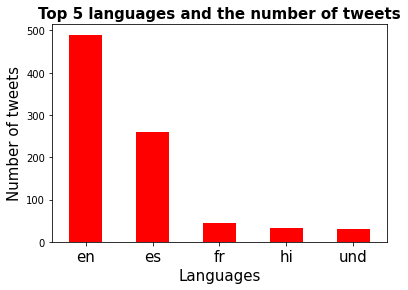

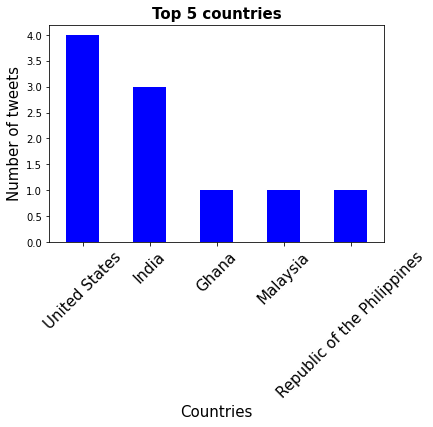

In [49]:
fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Languages', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top 5 languages and the number of tweets', fontsize=15, fontweight='bold')
tweets_by_lang[:5].plot(ax=ax, kind='bar', color='red', rot=0)

tweets_by_country = tweets['country'].value_counts()

fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Countries', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top 5 countries', fontsize=15, fontweight='bold')
tweets_by_country[:5].plot(ax=ax, kind='bar', color='blue', rot=45,)